In [1]:
# !pip install pandas matplotlib seaborn ipywidgets squarify numpy

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, widgets, interactive
import squarify
from IPython.display import display, HTML
import numpy as np

data = pd.read_csv('https://raw.githubusercontent.com/kaiimran/voila-railway/main/shopee_product_category_by_partner_type.csv')

data['conversion_count'] = pd.to_numeric(data['conversion_count'], errors='coerce')
data['usd_avg_sale_per_conv'] = pd.to_numeric(data['usd_avg_sale_per_conv'], errors='coerce')
data['myr_avg_sale_per_conv'] = pd.to_numeric(data['myr_avg_sale_per_conv'], errors='coerce')

columns_to_format = [
    'conversion_count', 'usd_avg_sale_per_conv', 'myr_avg_sale_per_conv'
]

# Convert 'month_conversion' to datetime
data['month_conversion'] = pd.to_datetime(data['month_conversion'])

# data.dtypes

# Shopee Conversion Analysis by Category

In [13]:
# Filter for Q2 2024
def filter_data_for_q2(data):
    return data[(data['month_conversion'] >= '2024-04-01') & (data['month_conversion'] < '2024-07-01')]

def plot_metric_bar_chart(metric):
    metric_mapping = {
        'Total Conversion': 'conversion_count',
        'Total Sales (USD)': 'usd_sale_amount',
        'Total Revenue (USD)': 'usd_revenue',
        'Total Payout (USD)': 'usd_payout',
    }
    
    column = metric_mapping[metric]
    
    # Filter data for Q2 2024
    filtered_data = filter_data_for_q2(data)
    
    # Group data by region and sum the selected metric
    metric_by_region = filtered_data.groupby('shopee_region')[column].sum()
    
    # Create the bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    metric_by_region.plot(kind='bar', ax=ax, color='skyblue')
    
    plt.title(f'{metric} by Region (Q2 2024)', fontsize=18)
    plt.xlabel('Region', fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    
    # Add value labels on top of the bars
    for index, value in enumerate(metric_by_region):
        if metric in ['Total Sales (USD)', 'Total Revenue (USD)', 'Total Payout (USD)']:
            label = f'${value:,.0f}'
        else:
            label = f'{value:,.0f}'
        ax.text(index, value, label, ha='center', va='bottom')
    
    plt.show()

# Create dropdown widgets for metric selection
metric_options = [
    'Total Conversion',
    'Total Sales (USD)',
    'Total Revenue (USD)',
    'Total Payout (USD)',
]

interactive_plot = interactive(
    plot_metric_bar_chart,
    metric=widgets.Dropdown(
        options=metric_options,
        value='Total Revenue (USD)',
        description='Metric:'
    )
)

display(interactive_plot)

interactive(children=(Dropdown(description='Metric:', index=2, options=('Total Conversion', 'Total Sales (USD)…

__________________________________________________________________________________________________________________

In [12]:
def plot_percent_stacked_bar_chart(metric):
    metric_mapping = {
        'Total Conversion': 'conversion_count',
        'Total Sales (USD)': 'usd_sale_amount',
        'Total Revenue (USD)': 'usd_revenue',
        'Total Payout (USD)': 'usd_payout',
    }
    column = metric_mapping[metric]
    
    # Group data by region and category
    grouped_data = data.groupby(['shopee_region', 'english_product_category'])[column].sum().unstack(fill_value=0)
    
    # Calculate percentages
    percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100
    
    # Sort categories by total value across all regions
    category_totals = grouped_data.sum()
    sorted_categories = category_totals.sort_values(ascending=False).index
    
    # Select top 10 categories
    top_categories = sorted_categories[:10]
    
    # Create a new DataFrame with top 10 categories and 'Others'
    percentages_top10 = percentages[top_categories].copy()
    percentages_top10['Others'] = 100 - percentages_top10.sum(axis=1)
    
    # Sort the DataFrame so that the largest category is first and 'Others' is last
    cols = ['Others'] + list(top_categories)[::-1]
    percentages_top10 = percentages_top10[cols]
    
    # Create the 100% stacked bar chart
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Use a colormap to ensure distinct colors, reversing the order to match the data
    # Updated line to address the deprecation warning:
    colors = plt.colormaps['tab20'](np.linspace(0, 1, len(cols)))[::-1]
    
    percentages_top10.plot(kind='bar', stacked=True, ax=ax, color=colors)
    plt.title(f'Proportion of {metric} by Region and Top 10 Categories', fontsize=18)
    plt.xlabel('Region', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    
    # Customize legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Add percentage labels
    for c in ax.containers:
        labels = [f'{v.get_height():.1f}%' if v.get_height() > 1 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center')
    
    # Set y-axis to go from 0 to 100
    ax.set_ylim(0, 100)
    plt.show()

# Create dropdown widgets for metric selection
metric_options = [
    'Total Conversion',
    'Total Sales (USD)',
    'Total Revenue (USD)',
    'Total Payout (USD)',
]
metric_dropdown = widgets.Dropdown(options=metric_options, value='Total Sales (USD)', description='Metric:')

# Use interact to create an interactive plot
interact(plot_percent_stacked_bar_chart, metric=metric_dropdown)

interactive(children=(Dropdown(description='Metric:', index=1, options=('Total Conversion', 'Total Sales (USD)…

<function __main__.plot_percent_stacked_bar_chart(metric)>

__________________________________________________________________________________________________________________

In [5]:
# Function to create a treemap of categories by the selected metric
def plot_treemap(metric, region='All regions'):
    # Map metrics to columns
    metric_mapping = {
        'Total Conversion': 'conversion_count',
        'Total Sales (USD)': 'usd_sale_amount',
        'Total Revenue (USD)': 'usd_revenue',
        'Total Payout (USD)': 'usd_payout',
    }
    
    # Select the correct column based on the metric
    column = metric_mapping[metric]
    
    # Filter the data based on the selected region
    if region == 'All regions':
        sales_data = data.groupby('english_product_category')[column].sum().reset_index()
    else:
        sales_data = data[data['shopee_region'] == region].groupby('english_product_category')[column].sum().reset_index()
    
    # Sort by the selected metric and get the top 15 categories
    sales_data = sales_data.sort_values(column, ascending=False).head(15)
    
    # Create the treemap
    plt.figure(figsize=(16, 10))
    squarify.plot(sizes=sales_data[column], 
                  label=sales_data['english_product_category'], 
                  alpha=0.8,
                  value=sales_data[column].map('${:,.0f}'.format) if column == 'usd_sale_amount' else None)
    
    plt.title(f'Top 15 Categories by {metric} - {region}', fontsize=18)
    plt.axis('off')
    plt.show()

# Create dropdown widgets for metric and region selection
metric_options = [
    'Total Conversion',
    'Total Sales (USD)',
    'Total Revenue (USD)',
    'Total Payout (USD)',
]
metric_dropdown = widgets.Dropdown(options=metric_options, value='Total Sales (USD)', description='Metric:')

region_options = ['All regions'] + sorted(data['shopee_region'].unique().tolist())
region_dropdown = widgets.Dropdown(options=region_options, value='All regions', description='Region:')

# Use interact to make the treemap dynamic
widgets.interact(plot_treemap, metric=metric_dropdown, region=region_dropdown)

interactive(children=(Dropdown(description='Metric:', index=1, options=('Total Conversion', 'Total Sales (USD)…

<function __main__.plot_treemap(metric, region='All regions')>

__________________________________________________________________________________________________________________

In [6]:
def rank_categories(metric, region='All regions'):
    metric_mapping = {
        'Total Conversion': 'conversion_count',
        'Total Sales (USD)': 'usd_sale_amount',
        'Total Revenue (USD)': 'usd_revenue',
        'Total Payout (USD)': 'usd_payout',
    }
    
    column = metric_mapping[metric]
    
    # Filter by region if a specific region is selected
    if region != 'All regions':
        filtered_data = data[data['shopee_region'] == region]
    else:
        filtered_data = data
    
    # Group and sum the data by category
    ranked_categories = filtered_data.groupby('english_product_category')[column].sum().sort_values(ascending=False).reset_index()
    
    # Add column names
    ranked_categories.columns = ['Category', metric]
    
    # Calculate the percentage of each category's value relative to the total
    total_value = ranked_categories[metric].sum()
    ranked_categories['Percentage'] = (ranked_categories[metric] / total_value) * 100
    
    # Format the values and create a combined column for display
    if column == 'conversion_count':
        ranked_categories['Display'] = ranked_categories.apply(lambda row: f"{int(row[metric]):,} ({row['Percentage']:.2f}%)", axis=1)
    else:
        ranked_categories['Display'] = ranked_categories.apply(lambda row: f"{row[metric]:,.2f} ({row['Percentage']:.2f}%)", axis=1)
    
    return ranked_categories

def plot_ranked_categories(metric, region):
    ranked_data = rank_categories(metric, region)
    
    # Calculate the figure height based on the number of categories
    fig_height = max(8, 0.4 * len(ranked_data))
    plt.figure(figsize=(12, fig_height))
    
    ax = sns.barplot(y='Category', x=metric, data=ranked_data, orient='h')
    
    # Add value labels on the bars
    for i, v in enumerate(ranked_data[metric]):
        ax.text(v, i, f' {ranked_data["Display"].iloc[i]}', va='center')
    
    plt.title(f"Categories Ranked by {metric} - {region}")
    plt.tight_layout()
    plt.show()

# Create dropdown widgets for metric selection
metric_options = [
    'Total Conversion',
    'Total Sales (USD)',
    'Total Revenue (USD)',
    'Total Payout (USD)',
]
metric_dropdown = widgets.Dropdown(options=metric_options, value='Total Sales (USD)', description='Metric:')

# Create a dropdown widget for region selection
region_options = ['All regions'] + sorted(data['shopee_region'].unique().tolist())
region_dropdown = widgets.Dropdown(options=region_options, value='All regions', description='Region:')

# Use interact to create an interactive plot with both metric and region filters
widgets.interact(plot_ranked_categories, metric=metric_dropdown, region=region_dropdown)

interactive(children=(Dropdown(description='Metric:', index=1, options=('Total Conversion', 'Total Sales (USD)…

<function __main__.plot_ranked_categories(metric, region)>

__________________________________________________________________________________________________________________

In [7]:
# Analyze sales trend over time, grouped by Shopee region
def plot_sales_trend(metric, category='All'):
    metric_mapping = {
        'Total Conversion': 'conversion_count',
        'Total Sales (USD)': 'usd_sale_amount',
        'Total Revenue (USD)': 'usd_revenue',
        'Total Payout (USD)': 'usd_payout',
    }
    
    column = metric_mapping[metric]
    
    if category == 'All':
        monthly_sales = data.groupby(['month_conversion', 'shopee_region'])[column].sum().reset_index()
    else:
        monthly_sales = data[data['english_product_category'] == category].groupby(['month_conversion', 'shopee_region'])[column].sum().reset_index()
    
    plt.figure(figsize=(15, 8))
    for region in monthly_sales['shopee_region'].unique():
        region_data = monthly_sales[monthly_sales['shopee_region'] == region]
        plt.plot(region_data['month_conversion'], region_data[column], marker='o', label=region)
    
    plt.title(f'Monthly Trend for {metric} in 2024 by Region ({category})', fontsize=18)
    plt.xlabel('Month')
    plt.ylabel('Total Sales (USD)')
    plt.legend(title='Shopee Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
# Create dropdown widgets for metric selection
metric_options = [
    'Total Conversion',
    'Total Sales (USD)',
    'Total Revenue (USD)',
    'Total Payout (USD)',
]
metric_dropdown = widgets.Dropdown(options=metric_options, value='Total Sales (USD)', description='Metric:')

# Create a dropdown widget for category selection
category_options = ['All'] + list(data['english_product_category'].unique())
category_dropdown = widgets.Dropdown(options=category_options, value='All', description='Category:')

# Use interact to create an interactive plot
interact(plot_sales_trend, category=category_dropdown, metric=metric_dropdown)

interactive(children=(Dropdown(description='Metric:', index=1, options=('Total Conversion', 'Total Sales (USD)…

<function __main__.plot_sales_trend(metric, category='All')>

Keep in mind: ‘Others’ category for Shopee Indonesia jumped from 557 conversion in March to 306K in April because Shopee Indonesia send null category in their conversions data.

__________________________________________________________________________________________________________________

In [8]:
def plot_category_trend(metric, region, category1, category2, category3, category4, category5, category6, category7):
    metric_mapping = {
        'Total Conversion': 'conversion_count',
        'Total Sales (USD)': 'usd_sale_amount',
        'Total Revenue (USD)': 'usd_revenue',
        'Total Payout (USD)': 'usd_payout',
    }
    
    column = metric_mapping[metric]
    
    if region == 'All regions':
        filtered_data = data
    else:
        filtered_data = data[data['shopee_region'] == region]
    
    selected_categories = [cat for cat in [category1, category2, category3, category4, category5, category6, category7] if cat != 'None']
    
    plt.figure(figsize=(15, 8))
    
    for category in selected_categories:
        if category == 'All':
            category_data = filtered_data.groupby('month_conversion')[column].sum().reset_index()
        else:
            category_data = filtered_data[filtered_data['english_product_category'] == category].groupby('month_conversion')[column].sum().reset_index()
        
        plt.plot(category_data['month_conversion'], category_data[column], marker='o', label=category)
    
    plt.title(f'Monthly Trend for {metric} in 2024 by Product Category ({region})', fontsize=18)
    plt.xlabel('Month')
    plt.ylabel(metric)
    plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create dropdown widgets for metric selection
metric_options = [
    'Total Conversion',
    'Total Sales (USD)',
    'Total Revenue (USD)',
    'Total Payout (USD)',
]
metric_dropdown = widgets.Dropdown(options=metric_options, value='Total Sales (USD)', description='Metric:')

# Create dropdown widgets for region selection
region_options = ['All regions'] + sorted(data['shopee_region'].unique().tolist())
region_dropdown = widgets.Dropdown(options=region_options, value='All regions', description='Region:')

# Create 7 dropdown widgets for category selection
category_options = ['All categories', 'None'] + sorted(data['english_product_category'].unique().tolist())
default_categories = [
    "Home & Living", "Tickets, Vouchers & Services", "Beauty", "Mobile & Gadgets",
    "Health", "Home Appliances", "Food & Beverage"
]

category_dropdowns = [
    widgets.Dropdown(
        options=category_options,
        value=default_categories[i] if i < len(default_categories) else 'None',
        description=f'Category {i+1}:'
    ) for i in range(7)
]

# Use interact to create an interactive plot
interact(plot_category_trend, 
         metric=metric_dropdown, 
         region=region_dropdown,
         category1=category_dropdowns[0],
         category2=category_dropdowns[1],
         category3=category_dropdowns[2],
         category4=category_dropdowns[3],
         category5=category_dropdowns[4],
         category6=category_dropdowns[5],
         category7=category_dropdowns[6])

interactive(children=(Dropdown(description='Metric:', index=1, options=('Total Conversion', 'Total Sales (USD)…

<function __main__.plot_category_trend(metric, region, category1, category2, category3, category4, category5, category6, category7)>

__________________________________________________________________________________________________________________

In [9]:
def plot_category_metric_comparison(category, metric, stat_type):
    # Filter data by category
    filtered_data = data[data['english_product_category'] == category]
    
    metric_mapping = {
        'Total Conversion': 'conversion_count',
        'Total Sales (USD)': 'usd_sale_amount',
        'Total Revenue (USD)': 'usd_revenue',
        'Total Payout (USD)': 'usd_payout',
    }
    column = metric_mapping[metric]
    
    # Group by region and calculate total conversion count and sum of metric
    grouped = filtered_data.groupby('shopee_region').agg({
        'conversion_count': 'sum',
        column: 'sum'
    }).reset_index()
    
    # Calculate average metric per conversion
    grouped['avg_per_conversion'] = grouped[column] / grouped['conversion_count']
    
    if stat_type == 'Average':
        region_stat = grouped.sort_values('avg_per_conversion', ascending=False)
        stat_column = 'avg_per_conversion'
    else:  # Median
        # For median, we need to calculate it manually
        def weighted_median(group):
            sorted_data = group.sort_values(column)
            cumsum = sorted_data['conversion_count'].cumsum()
            cutoff = group['conversion_count'].sum() / 2
            return sorted_data[cumsum >= cutoff][column].iloc[0] / sorted_data[cumsum >= cutoff]['conversion_count'].iloc[0]
        
        region_stat = filtered_data.groupby('shopee_region').apply(weighted_median).sort_values(ascending=False).reset_index()
        region_stat.columns = ['shopee_region', 'median_per_conversion']
        stat_column = 'median_per_conversion'

    plt.figure(figsize=(12, 6))
    sns.barplot(x=stat_column, y='shopee_region', data=region_stat)

    plt.title(f'Distribution of {stat_type} {metric} per Conversion by Region\nCategory: {category}')
    plt.xlabel(f'{stat_type} {metric} per Conversion')
    plt.ylabel('Region')
    plt.tight_layout()
    
    # Add value labels to the end of each bar
    for i, v in enumerate(region_stat[stat_column]):
        if metric != 'Total Conversion':
            label = f'${v:,.2f}'
        else:
            label = f'{v:,.2f}'
        plt.text(v, i, label, va='center')
    
    plt.show()

# Get unique categories
category_options = sorted(data['english_product_category'].unique())
category_dropdown = widgets.Dropdown(options=category_options, value=category_options[0], description='Category:')

metric_options = [
    'Total Conversion',
    'Total Sales (USD)',
    'Total Revenue (USD)',
    'Total Payout (USD)',
]
metric_dropdown = widgets.Dropdown(options=metric_options, value='Total Sales (USD)', description='Metric:')

stat_type_options = ['Average', 'Median']
stat_type_dropdown = widgets.Dropdown(options=stat_type_options, value='Average', description='Statistic:')

# Use interact to create an interactive plot
interact(plot_category_metric_comparison,
         category=category_dropdown,
         metric=metric_dropdown, 
         stat_type=stat_type_dropdown)

interactive(children=(Dropdown(description='Category:', options=('Audio', 'Automobiles', 'Baby & Kids Fashion'…

<function __main__.plot_category_metric_comparison(category, metric, stat_type)>

__________________________________________________________________________________________________________________

In [10]:
def plot_category_price_distribution(region, metric, stat_type):
    # Filter data by region if not 'All'
    if region != 'All regions':
        filtered_data = data[data['shopee_region'] == region]
    else:
        filtered_data = data
    
    metric_mapping = {
        'Sale Amount': 'usd_sale_amount',
        'Revenue': 'usd_revenue',
        'Payout': 'usd_payout',
    }
    column = metric_mapping[metric]
    
    # Group by category and calculate total conversion count and sum of metric
    grouped = filtered_data.groupby('english_product_category').agg({
        'conversion_count': 'sum',
        column: 'sum'
    }).reset_index()
    
    # Calculate average metric per conversion
    grouped['avg_per_conversion'] = grouped[column] / grouped['conversion_count']
    
    if stat_type == 'Average':
        category_stat = grouped.sort_values('avg_per_conversion', ascending=False)
    else:  # Median
        # For median, we need to calculate it manually
        def weighted_median(group):
            sorted_data = group.sort_values(column)
            cumsum = sorted_data['conversion_count'].cumsum()
            cutoff = group['conversion_count'].sum() / 2
            return sorted_data[cumsum >= cutoff][column].iloc[0] / sorted_data[cumsum >= cutoff]['conversion_count'].iloc[0]
        
        category_stat = filtered_data.groupby('english_product_category').apply(weighted_median).sort_values(ascending=False).reset_index()
        category_stat.columns = ['english_product_category', 'median_per_conversion']

    plt.figure(figsize=(15, 8))
    if stat_type == 'Average':
        sns.barplot(x='avg_per_conversion', y='english_product_category', data=category_stat)
        values = category_stat['avg_per_conversion']
    else:
        sns.barplot(x='median_per_conversion', y='english_product_category', data=category_stat)
        values = category_stat['median_per_conversion']

    plt.title(f'Distribution of {stat_type} {metric} per Conversion by Category ({region})')
    plt.xlabel(f'{stat_type} {metric} per Conversion (USD)')
    plt.ylabel('Product Category')
    plt.tight_layout()
    
    # Add value labels to the end of each bar
    for i, v in enumerate(values):
        plt.text(v, i, f'${v:,.2f}', va='center')
    
    plt.show()

region_options = ['All regions'] + list(data['shopee_region'].unique())
region_dropdown = widgets.Dropdown(options=region_options, value='All regions', description='Region:')

metric_options = ['Sale Amount', 'Revenue', 'Payout']
metric_dropdown = widgets.Dropdown(options=metric_options, value='Sale Amount', description='Metric:')

stat_type_options = ['Average', 'Median']
stat_type_dropdown = widgets.Dropdown(options=stat_type_options, value='Average', description='Statistic:')

# Use interact to create an interactive plot
interact(plot_category_price_distribution,
         region=region_dropdown,
         metric=metric_dropdown, 
         stat_type=stat_type_dropdown)

interactive(children=(Dropdown(description='Region:', options=('All regions', 'Shopee Vietnam', 'Shopee Malays…

<function __main__.plot_category_price_distribution(region, metric, stat_type)>

__________________________________________________________________________________________________________________

In [11]:
# Find gaps of publisher types that we can fill between countries

def plot_stacked_bar_chart(metric, category):
    metric_mapping = {
        'Total Conversion': 'conversion_count',
        'Total Sales (USD)': 'usd_sale_amount',
        'Total Revenue (USD)': 'usd_revenue',
        'Total Payout (USD)': 'usd_payout',
    }
    
    column = metric_mapping[metric]
    
    # Filter data for the selected category
    if category == 'All':
        filtered_data = data
    else:
        filtered_data = data[data['english_product_category'] == category]

    # Group data by region and partner type
    grouped_data = filtered_data.groupby(['shopee_region', 'partner_type'])[column].sum().unstack()

    # Create the stacked bar chart
    fig, ax = plt.subplots(figsize=(15, 8))
    grouped_data.plot(kind='bar', stacked=True, ax=ax)

    plt.title(f'{metric} by Region and Partner Type\nCategory: {category}', fontsize=18)
    plt.xlabel('Region', fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.legend(title='Partner Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create dropdown widgets for metric selection
metric_options = [
    'Total Conversion',
    'Total Sales (USD)',
    'Total Revenue (USD)',
    'Total Payout (USD)',
]
metric_dropdown = widgets.Dropdown(options=metric_options, value='Total Sales (USD)', description='Metric:')

# Create a dropdown widget for category selection
category_options = ['All'] + sorted(data['english_product_category'].unique().tolist())
category_dropdown = widgets.Dropdown(options=category_options, value='All', description='Category:')

# Use interact to create an interactive plot
interact(plot_stacked_bar_chart, metric=metric_dropdown, category=category_dropdown)

interactive(children=(Dropdown(description='Metric:', index=1, options=('Total Conversion', 'Total Sales (USD)…

<function __main__.plot_stacked_bar_chart(metric, category)>

__________________________________________________________________________________________________________________

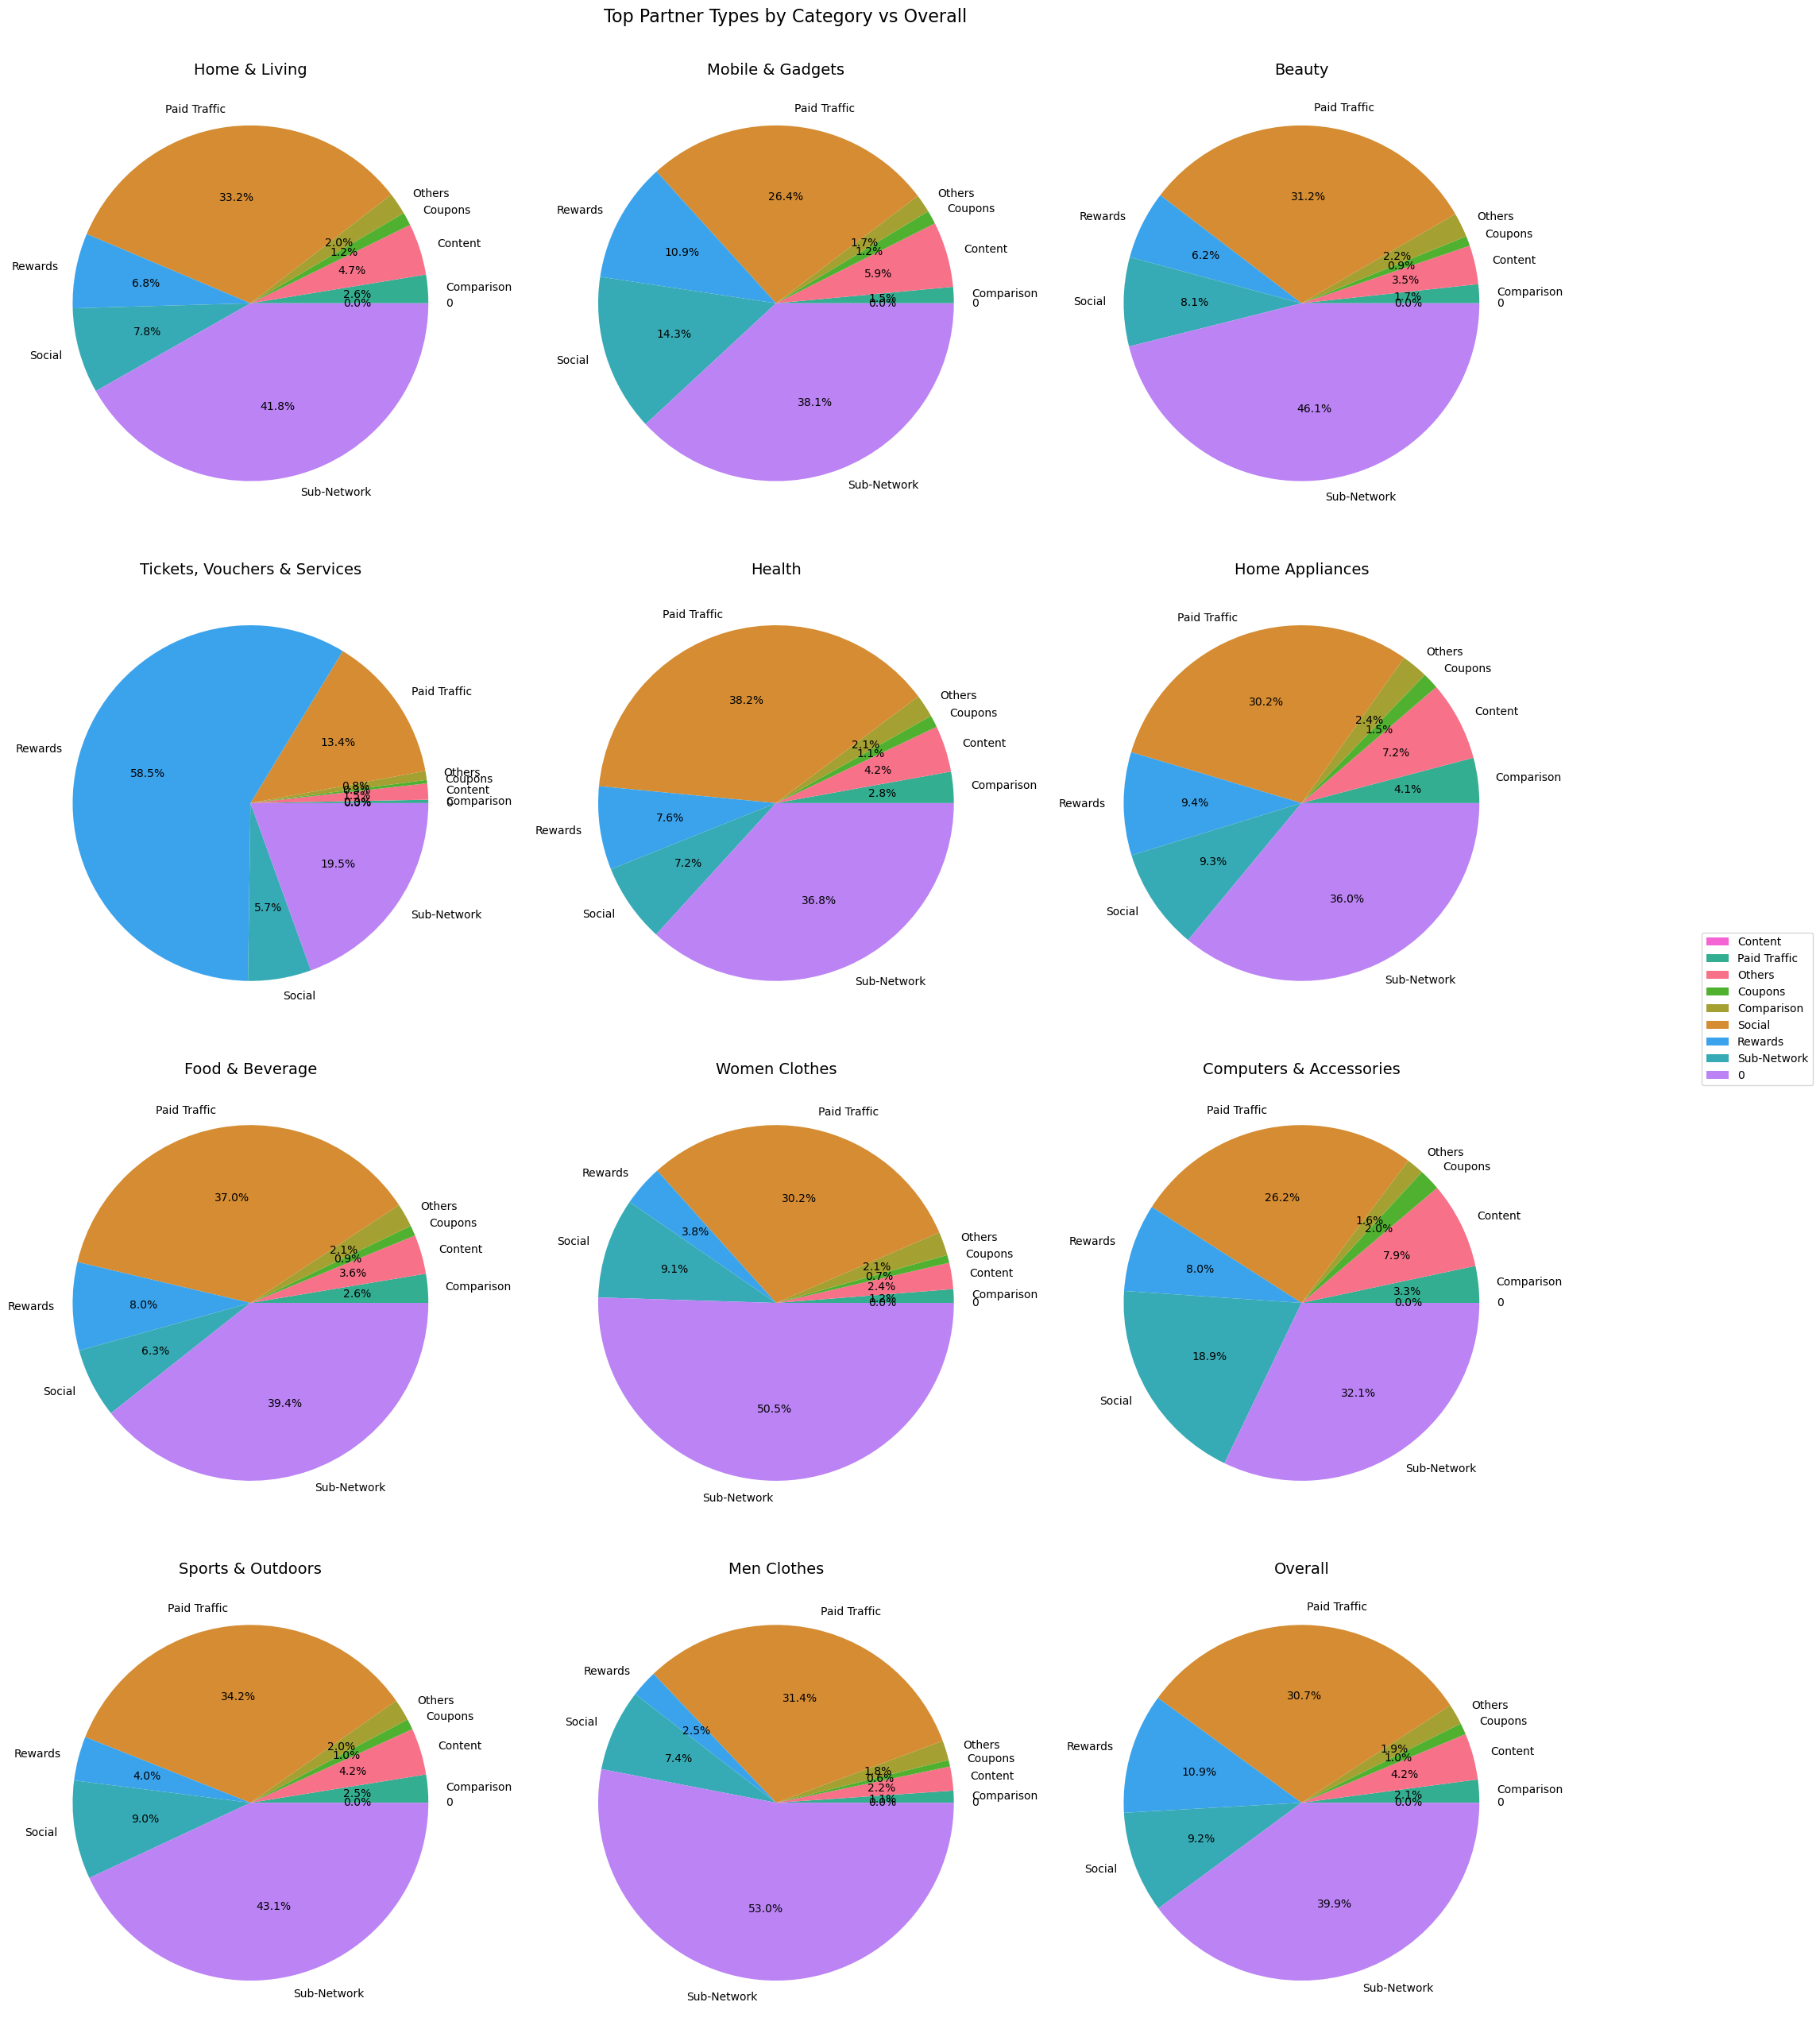

In [12]:
# For each category, what is the top partner type (pie chart) vs overall at the side. something like subplot

def plot_partner_types_by_category(data, top_n=11):
    # Get top N categories by total sales
    top_categories = data.groupby('english_product_category')['usd_sale_amount'].sum().nlargest(top_n).index
    # Get all unique partner types
    all_partner_types = data['partner_type'].unique()
    # Create a color palette for all partner types
    color_palette = sns.color_palette("husl", n_colors=len(all_partner_types))
    color_map = dict(zip(all_partner_types, color_palette))
    # Set up the subplot grid
    fig, axes = plt.subplots(4, 3, figsize=(20, 28))  # Increased height
    fig.suptitle('Top Partner Types by Category vs Overall', fontsize=16, y=0.95)  # Adjusted y position
    axes = axes.flatten()
    # Plot for each top category
    for i, category in enumerate(top_categories):
        category_data = data[data['english_product_category'] == category]
        partner_type_sales = category_data.groupby('partner_type')['usd_sale_amount'].sum()
        
        # Get colors for the present partner types
        colors = [color_map[pt] for pt in partner_type_sales.index]
        
        axes[i].pie(partner_type_sales.values, labels=partner_type_sales.index, autopct='%1.1f%%', colors=colors)
        axes[i].set_title(f'{category}', fontsize=14)
    # Plot overall partner type distribution
    overall_partner_type_sales = data.groupby('partner_type')['usd_sale_amount'].sum()
    colors = [color_map[pt] for pt in overall_partner_type_sales.index]
    axes[-1].pie(overall_partner_type_sales.values, labels=overall_partner_type_sales.index, autopct='%1.1f%%', colors=colors)
    axes[-1].set_title('Overall', fontsize=14)
    # Add a legend
    fig.legend(all_partner_types, loc='center right', bbox_to_anchor=(1.15, 0.5))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to accommodate the suptitle
    plt.show()

plot_partner_types_by_category(data)

__________________________________________________________________________________________________________________

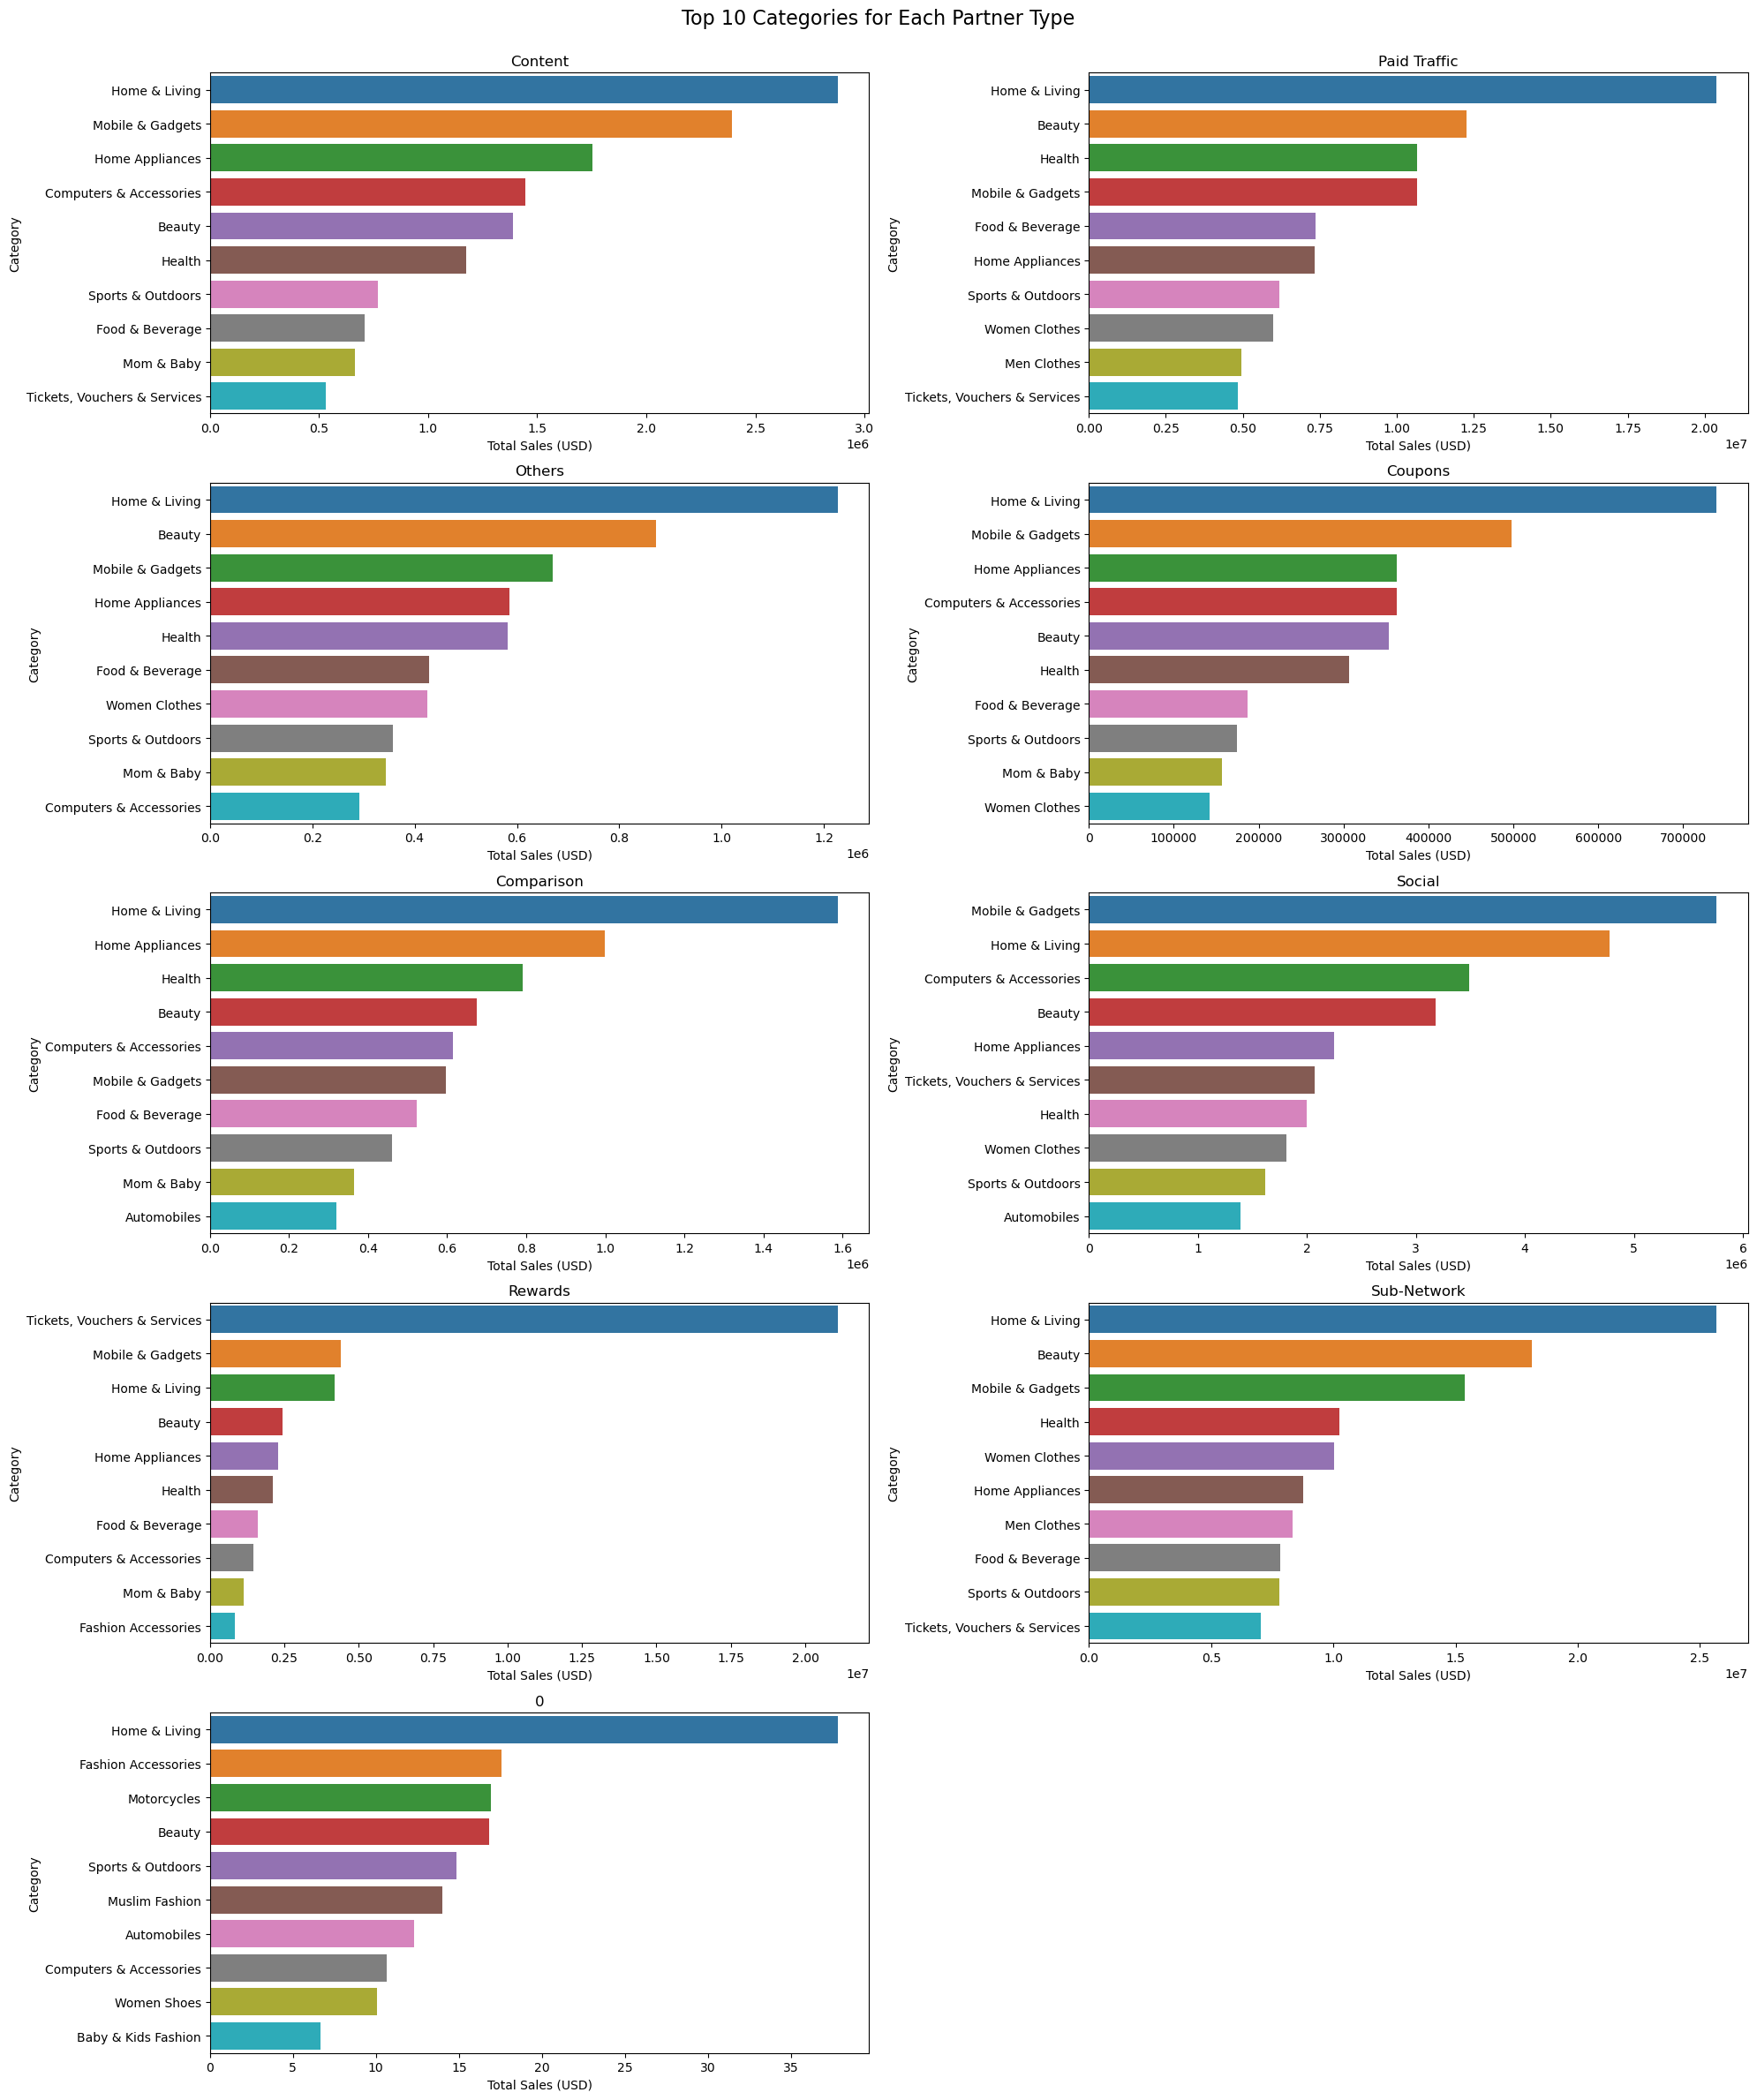

In [13]:
# For each partner type, what is the top 10 categories (bar chart)

def plot_top_categories_by_partner_type(data, top_n=10):
    partner_types = data['partner_type'].unique()
    n_partners = len(partner_types)
    
    # Determine number of rows and columns for the grid
    ncols = 2  # Change this for more or fewer columns
    nrows = np.ceil(n_partners / ncols).astype(int)

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 5 * nrows))  # Adjust overall size
    axes = axes.flatten()  # Flatten to easily iterate

    fig.suptitle('Top 10 Categories for Each Partner Type', fontsize=16)
    
    for i, partner_type in enumerate(partner_types):
        partner_data = data[data['partner_type'] == partner_type]
        top_categories = partner_data.groupby('english_product_category')['usd_sale_amount'].sum().nlargest(top_n)

        sns.barplot(x=top_categories.values, y=top_categories.index, ax=axes[i])
        axes[i].set_title(f'{partner_type}')
        axes[i].set_xlabel('Total Sales (USD)')
        axes[i].set_ylabel('Category')
    
    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])  # Adjust layout to prevent overlap with suptitle
    plt.show()

plot_top_categories_by_partner_type(data)
